In [1]:
import numpy as np 
import pandas as pd


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle
 95% 25.0M/26.4M [00:00<00:00, 38.0MB/s]
100% 26.4M/26.4M [00:00<00:00, 59.5MB/s]


In [3]:
!ls 
!unzip \*.zip&& rm *.zip
!ls

 entity-annotated-corpus.zip   kaggle.json
 glove.6B.100d.txt	       Musical_Instruments_5.json
 glove.6B.200d.txt	       Musical_instruments_reviews.csv
 glove.6B.300d.txt	       train.csv
 glove.6B.50d.txt	       valid.csv
'IMDB Dataset.csv'
Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         
 glove.6B.100d.txt  'IMDB Dataset.csv'		       ner.csv
 glove.6B.200d.txt   kaggle.json		       ner_dataset.csv
 glove.6B.300d.txt   Musical_Instruments_5.json        train.csv
 glove.6B.50d.txt    Musical_instruments_reviews.csv   valid.csv


In [4]:
dframe = pd.read_csv('ner.csv', encoding="ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [5]:
dframe.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [6]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [7]:
dataset = dframe[['word', 'pos', 'sentence_idx', 'tag']].copy()

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   word          1050794 non-null  object 
 1   pos           1050794 non-null  object 
 2   sentence_idx  1050794 non-null  float64
 3   tag           1050794 non-null  object 
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


In [9]:
dataset.head(2)

,word,pos,sentence_idx,tag
0,Thousands,NNS,1.0,O
1,of,IN,1.0,O


In [10]:
class SentenceGetter(object):


    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), 
                                                     s["tag"].values.tolist())]

        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]


    

    def get_next(self):
        try: 
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s 
        except: 
            return None

In [14]:
getter = SentenceGetter(dataset)

In [15]:
sentences = getter.sentences

In [16]:
print(sentences[5])

[('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [17]:
maxlen = max([len(s) for s in sentences])
print("Maximum sequence length:", maxlen)

Maximum sequence length: 140


In [18]:
# check how long sentences are so that we can pad them 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

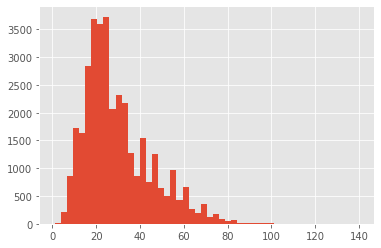

In [19]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [20]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")
n_words = len(words)
n_words

30174

In [21]:
tags = list(set(dataset["tag"].values))
n_tags = len(tags)
n_tags

18

In [22]:
# Converting words to numbers and numbers to words

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [24]:
word2idx['Obama']

27579

In [26]:
word2idx['the']

321

In [27]:
tag2idx["O"]

4

In [29]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X[0]

[28816,
 13767,
 1145,
 18801,
 13932,
 10390,
 6591,
 574,
 18369,
 321,
 7330,
 7743,
 22251,
 11036,
 23018,
 321,
 15597,
 13767,
 11268,
 26936,
 26508,
 15064,
 19147,
 27593,
 28816,
 13767,
 1145,
 18801,
 13932,
 10390,
 6591,
 574,
 18369,
 321,
 7330,
 7743,
 22251,
 11036,
 23018,
 321,
 15597,
 13767,
 11268,
 26936,
 26508,
 15064,
 19147,
 27593]

In [30]:
X = pad_sequences(maxlen=140, sequences=X, padding="post", value=n_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [32]:
for i in y: 
    print(i)
    break

[ 4  4  4  4  4  4 10  4  4  4  4  4 10  4  4  4  4  4 11  4  4  4  4  4
  4  4  4  4  4  4 10  4  4  4  4  4 10  4  4  4  4  4 11  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]


In [33]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [34]:
y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
from keras.models import Model, Input 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [38]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [41]:
model = Model(input, out)

In [42]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

704/704 [==============================] - 527s 742ms/step - loss: 0.2949 - accuracy: 0.9602 - val_loss: 0.0406 - val_accuracy: 0.9889


[[4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]]


In [50]:
for i in [3,8,10,6]:
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    print(p)
    print("{:14} ({:5}) {}".format("WORD", "TRUE", "PRED"))
    print("\n\n")
    for w, pred in zip(X_test[i], p[0]):
        #print(w, pred)
        if tags[pred] !='O':
            print("{:14}: {}".format(words[w], tags[pred]))

[[4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
  4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]]
WORD           (TRUE ) PRED



Sunday        : B-tim
Sunday        : B-tim
[[16  7  4  4  4  4 10  1  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4 10  2  4  4  4  4  4  4  4 16  7  4  4  4  4 10  1  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4 10  2  4  4  4  4  4  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
   4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]]
WORD           (TRUE ) PRED



Mr.           : B-per
Carter        : I-per
Atlanta       : B-geo
Tuesday       : B-tim
United        : B-geo
States        : I-geo
Mr.           : B-per
Carter        : 